In [1]:
from unityagents import UnityEnvironment
import numpy as np
import agent
import random

## Preparing the environment for training

In [2]:
path_to_env='../Reacher_Linux/Reacher.x86_64'

env = UnityEnvironment(file_name=path_to_env)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like:
 [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [ ]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

# Tests for memory usage
#myAgent = agent.Agent(3)
#l = myAgent.memory_size

for i in range(20):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actionsClipped = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    print(actionsClipped)
    env_info = env.step(actionsClipped)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    
    myAgent.add(states[0], actions[0], rewards[0], next_states[0], dones[0])
    for N, j in enumerate(rB.episode_len):
        l_now = len(myAgent.individual_memory)
        if ( l_now >= j):
            past_states = [myAgent.individual_memory[k].state for k in range(l_now-j,l_now)]
            past_actions = [myAgent.individual_memory[k].action for k in range(l_now-j,l_now)]
            past_rewards = [myAgent.individual_memory[k].reward for k in range(l_now-j,l_now)]
            past_next_states = [myAgent.individual_memory[k].next_state for k in range(l_now-j,l_now)]
            past_dones = [myAgent.individual_memory[k].done for k in range(l_now-j,l_now)]
            rB.add(past_states, past_actions, past_rewards, past_next_states, past_dones, N)
    
    states = next_states                               # roll over states to next time step
    #if np.any(dones):                                  # exit loop if episode finished
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [3]:
num_critics = 1 # Define the number of independant critics wanted

env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)

# Penalty coefficient for high actions
alphaTor = 0.0000025


# Create Critic Agents
critics = [] # agent list
crit_lrs = 1e-4 # np.exp(-2* np.log(10) * np.random.rand(20)) * 10**(-2)
for i in range(num_critics):
    model = agent.CriticModel(state_size, action_size)
    critic = agent.CriticAgent(model, crit_lrs)
    critics.append(critic)

# Create Actor Agents
workers = [] # agent list
crit2work = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# work_lrs = [1e-4,1e-3,1e-5,2e-4,2e-3,1e-4,2e-5,3e-4,3e-5,3e-4,2e-5,1e-3,1e-4,1e-5,2e-4,3e-4,3e-3,2e-5,5e-5,5e-4]
for i in range(num_agents):
    model = agent.ActorModel(state_size, action_size)
    critic = critics[0] #crit2work[i]]
    actor = agent.ActorAgent(model, critic, lr = 1e-4,memory_size = 3)
    actor.noise.theta = 0.2 # set theta in OUnoise
    actor.noise.sigma = 0.2 # set sigma in OUnoise
    workers.append(actor)
    

# Create the shared replay buffer
shared_memory = agent.ReplayBuffer(action_size, buffer_size = 1e4, batch_size = 4096, episode_len=[1])
scoreList = []
count = 0
start_learning = True # to identify when the agents start learning
while True:
    scores = np.zeros(num_agents)
    while True:
        # Select an action for each agent
        actions = []
        for i, worker in enumerate(workers):
            state = states[i]
            action = worker.act(state)
            actions.append(action)

        # send the actions to the environment
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)

        # Memorize last actions
        for i, worker in enumerate(workers):
            # add a penalty for excessive torque (high action values)
            myReward = rewards[i] # - alphaTor * np.abs(actions[i].max())
            worker.add(states[i], actions[i], myReward, next_states[i], dones[i])
        # send individual memory to shared memory
        for spot, spotLength in enumerate(shared_memory.episode_len):
            for worker in workers:
                l = len(worker.individual_memory)
                if ( l >= spotLength): # check if the agent has enough steps in memory for the current shared memory spot
                    currentRange = range(l-spotLength, l)
                    past_states = [worker.individual_memory[k].state for k in currentRange]
                    past_actions = [worker.individual_memory[k].action for k in currentRange]
                    past_rewards = [worker.individual_memory[k].reward for k in currentRange]
                    past_next_states = [worker.individual_memory[k].next_state for k in currentRange]
                    past_dones = [worker.individual_memory[k].done for k in currentRange]
                    shared_memory.add(past_states, past_actions, past_rewards, past_next_states, past_dones, spot)
        # Train the critics
        # 1) generate a sample with the various length replaybuffers (use ReplayBuffer.sample and CriticAgent.evaluate)
        for i in range(len(shared_memory.episode_len)): # loop over the different spots
            if (len(shared_memory) > shared_memory.batch_size):
                if start_learning:
                    print("start learning")
                    start_learning = False
                Expstates, Expactions, Exprewards, Expnext_states, Expdones = shared_memory.sample(i) # sample the ith memory spot
            # 2) critic.learn
                for i, critic in enumerate(critics): # adapt for long episodes
                    # Expnext_state = Expnext_states[-1]
                    Expnext_actions = workers[i].act(Expnext_states, add_noise=False)
                    Expstate, Expaction, Expestimated_reward = critic.evaluate(Expstates.squeeze(), Expactions.squeeze(), Exprewards, Expnext_states.squeeze(), Expnext_actions.squeeze(), Expdones.squeeze())
                    critic.learn(Expstate, Expaction, Expestimated_reward)
                #train the actors
                for worker in workers:
                    worker.learn(Expstate)
            states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    if True: # count%10 == 0:
        print('Total score (averaged over agents) for episode {}: {}'.format(count ,np.mean(scores)))
    scoreList.append([scores])
    count += 1
    if np.mean(np.array(scoreList)[-100:]) > 30:
        break
print("Total mean score: {}".format(np.mean(scoreList)))

start learning
Total score (averaged over agents) for episode 0: 0.30449999319389465
Total score (averaged over agents) for episode 1: 0.2649999940767884
Total score (averaged over agents) for episode 2: 0.09649999784305692
Total score (averaged over agents) for episode 3: 0.32749999267980456
Total score (averaged over agents) for episode 4: 0.72049998389557
Total score (averaged over agents) for episode 5: 0.3849999913945794
Total score (averaged over agents) for episode 6: 0.6294999859295786
Total score (averaged over agents) for episode 7: 0.06049999864771962
Total score (averaged over agents) for episode 8: 0.04999999888241291
Total score (averaged over agents) for episode 9: 0.755499983113259
Total score (averaged over agents) for episode 10: 0.8849999802187085
Total score (averaged over agents) for episode 11: 0.3434999923221767
Total score (averaged over agents) for episode 12: 0.7419999834150076
Total score (averaged over agents) for episode 13: 0.9144999795593322
Total score (

KeyboardInterrupt: 

In [ ]:
Exprewards

In [ ]:
Expstates, Expactions, Exprewards, Expnext_states, Expdones = shared_memory.sample(0)
Expnext_actions = workers[0].act(Expnext_states)
Expstate, Expaction, Expestimated_reward = critic.evaluate(Expstates.squeeze(), Expactions.squeeze(), Exprewards, Expnext_states.squeeze(), Expnext_actions.squeeze(), Expdones.squeeze())
#Expnext_states.squeeze().shape
Expnext_actions

In [ ]:
Expstates.squeeze().shape

In [ ]:
# TO FIX! 
worker.act(Expnext_states[5], add_noise=False)

In [ ]:
import torch
critic.target(torch.from_numpy(Expnext_states.squeeze()).float().to("cuda"), torch.from_numpy(Expnext_actions.squeeze()).float().to("cuda")).cpu().data.numpy()

In [ ]:
scoreList

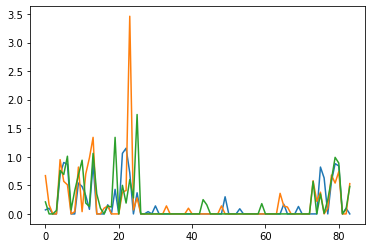

In [7]:
from matplotlib import pyplot as plt
for i in range(3):
    x = np.array(scoreList)[:,:,i]
    plt.plot(range(len(x)), x, label=i)
    #plt.legend()
    
plt.show()

In [ ]:
from matplotlib import pyplot as plt
#plt.plot(np.array(shared_memory.memory[0])[:,2,0])
np.sum((np.array(shared_memory.memory[0])[:,2,0]) > 0)

In [ ]:
workers[0].noise.theta

In [4]:
scoreList

[[array([0.07      , 0.66999999, 0.21      , 1.07999998, 0.        ,
         0.        , 0.44999999, 0.23999999, 0.28999999, 0.55999999,
         0.17      , 0.        , 0.        , 0.16      , 0.        ,
         0.        , 0.91999998, 0.78999998, 0.        , 0.47999999])],
 [array([0.1       , 0.16      , 0.        , 0.26999999, 0.57999999,
         1.66999996, 0.06      , 0.05      , 0.39999999, 0.24999999,
         0.2       , 0.        , 0.        , 0.22      , 0.14      ,
         0.79999998, 0.03      , 0.11      , 0.        , 0.25999999])],
 [array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.59999999, 0.        , 0.        , 0.05      ,
         0.        , 0.1       , 0.03      , 0.        , 0.        ,
         0.2       , 0.        , 0.94999998, 0.        , 0.        ])],
 [array([0.        , 0.        , 0.06      , 0.49999999, 0.22999999,
         0.        , 0.16      , 0.18      , 0.57999999, 2.10999995,
         0.        , 0.  

In [ ]:
Expnext_actions

In [ ]:
"""
state = torch.from_numpy(state).float().to(device)
        action = self.local(state).cpu().data.numpy()
        if add_noise:
            action += self.noise.sample()
        return action
        
"""

In [ ]:
import torch
import torch.nn.functional as F

states0, actions0 = torch.from_numpy(Expstates.squeeze()).float().to("cuda"), torch.from_numpy(Expactions.squeeze()).float().to("cuda")
# print("states: {}".format(states))
# print("actions: {}".format(actions))
Q_expected0 = critic.local(states0, actions0) # .cpu().data.numpy()
estimated_rewards0 = torch.from_numpy(Expestimated_reward).float().to("cuda")
# print("Q_expected: {}".format(Q_expected))
# print("estimated_rewards: {}".format(estimated_rewards))
critic_loss = mixed_loss(Q_expected0, estimated_rewards0)
print(critic_loss)

In [10]:
Expestimated_reward

array([[0.12323087],
       [0.12517715],
       [0.11110123],
       ...,
       [0.12253532],
       [0.12233887],
       [0.11569868]])

In [ ]:
estimated_rewards0[estimated_rewards0 > 1]

In [ ]:
def mixed_loss(expected, from_eval, threshold = 0.01, weigths = [5, 1]):
    if len(Q_expected0[estimated_rewards0 >= threshold]) > 0:
        a = F.mse_loss(expected[from_eval >= threshold], from_eval[from_eval >= threshold])
    else:
        a = 0
    if len(from_eval[from_eval < threshold]) > 0:
        b = F.mse_loss(expected[from_eval < threshold], from_eval[from_eval < threshold])
    else:
        b = 0
    return weigths[0] * a + weigths[1] * b

In [ ]:
 threshold = 0.01
F.mse_loss(Q_expected0[estimated_rewards0 < threshold], estimated_rewards0[estimated_rewards0 < threshold])

In [ ]:
len(Q_expected0[estimated_rewards0 >= threshold])